In [11]:
using Pkg
Pkg.activate("../.")

Hello Jeremy to the world of Trust-Region Tests!

  Activating project at `c:\Users\jerem\OneDrive\Desktop\GitHub\TrustRegionTests.jl`


In [12]:
using TrustRegionTests
greet("Jeremy")

Hello Jeremy to the world of Trust-Region Tests!

In [21]:
using NLPModels, QuadraticModels, LinearAlgebra, Plots
import NLPModels

In [22]:
struct myQuadModel{T, S} <: AbstractNLPModel{T, S}
    A::Matrix{T}
    b::Vector{T}
    c::T

    meta::NLPModelMeta{T, S}
    counters::Counters

    function myQuadModel{T}(A::Matrix{T}, b::Vector{T}, c::T) where {T}
        nvar = length(b)
        return new{T, Vector{T}}(A, b, c, 
                                NLPModelMeta(nvar; x0 = zeros(T, nvar)), 
                                Counters()
                                )
    end

    function myQuadModel{T}(A::Matrix{T}, b::Vector{T}, c::T, x0::AbstractVector{T}) where {T}
        nvar = length(b)
        return new{T, Vector{T}}(A, b, c, 
                                NLPModelMeta(nvar; x0 = x0), 
                                Counters()
                                )
    end
end

In [23]:
A = [
  6.0 2.0 1.0
  2.0 5.0 2.0
  1.0 2.0 4.0
]

b = [-8.0; -3; -3];

c = 3.0;

model = myQuadModel{Float64}(A, b, c)

myQuadModel{Float64, Vector{Float64}}
  Problem name: Generic
   All variables: ████████████████████ 3      All constraints: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            free: ████████████████████ 3                 free: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                lower: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                upper: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
         low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0              low/upp: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
           fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0                fixed: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
          infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0               infeas: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
            nnzh: (  0.00% sparsity)   6               linear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                    nonlinear: ⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅ 0     
                                                         nnzj: (------% sparsity)         

  Counters:
             ob

In [24]:
function NLPModels.obj(nlp::myQuadModel, x::AbstractVector{T}) where T
    return c + dot(nlp.b, x) + 0.5*dot(x, nlp.A*x)
end

function NLPModels.grad!(nlp::myQuadModel, x::AbstractVector{T}, g::AbstractVector{T}) where T
    g[:] = nlp.b + nlp.A*x
end

function hess(nlp::myQuadModel, x::AbstractVector{T}) where T
    return nlp.A
end 

hess (generic function with 1 method)

In [25]:
# Solution to Quadratic model 
xstar = - LinearAlgebra.inv(A)*b

3-element Vector{Float64}:
  1.289156626506024
 -0.10843373493975894
  0.4819277108433735

In [11]:
mysgd = Charlotte.SGDConstStep(0.001)

accs = [Charlotte.Value(), Charlotte.NGrad(), Charlotte.ParamAccumulator(), Charlotte.DistTo(xstar)]
acc = Charlotte.Accumulator(accs)

state, accumulator = mysgd(model; verbose = false, accumulator = acc);

all_acc_sgd = Charlotte.getData(accumulator);

Algorithm of type : Charlotte.SGDConstStep{Float64}
 --- STOP after 1001 iterations ---
 stop status: NMax
 fx = -2.7122998080157705
 norm grad = 0.14999463469430646


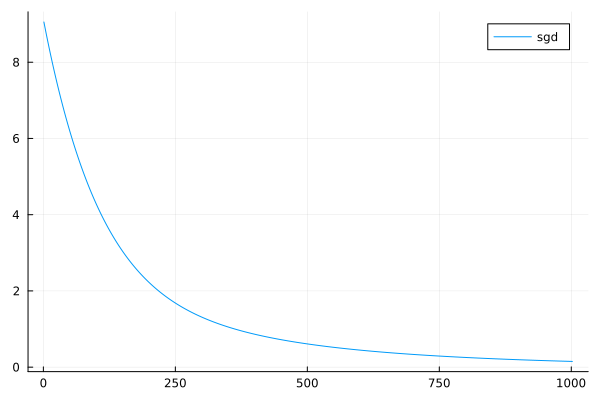

In [12]:
p = plot(all_acc_sgd[:NormGrad], label="sgd")

Algorithm of type : Charlotte.AdamConstStep{Float64}
 --- STOP after 525 iterations ---
 stop status: FixedGradientNorm
 fx = -2.7168674688925165
 norm grad = 9.70403699319664e-5


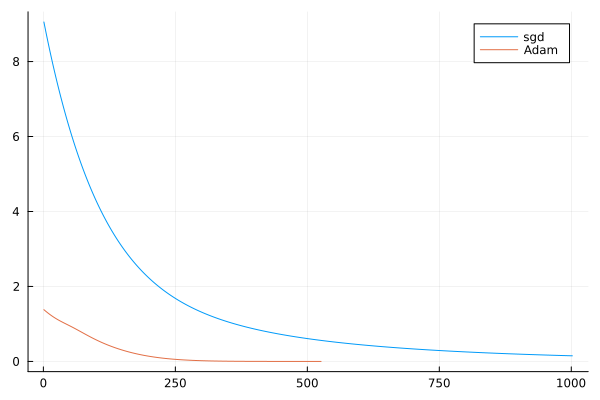

In [13]:
adam = Charlotte.AdamConstStep(0.01, 0.9, 0.999)

accs = [Charlotte.Value(), Charlotte.NGrad(), Charlotte.ParamAccumulator(), Charlotte.DistTo(xstar)]
acc = Charlotte.Accumulator(accs)

state, accumulator = adam(model; verbose = false, accumulator = acc);

all_acc_adam  = Charlotte.getData(accumulator);

plot!(p, all_acc_adam[:DistTo], label="Adam")

Algorithm of type : Charlotte.MomentumConstStep{Float64}
 --- STOP after 30 iterations ---
 stop status: FixedGradientNorm
 fx = -2.7168674695818664
 norm grad = 4.704386976479313e-5


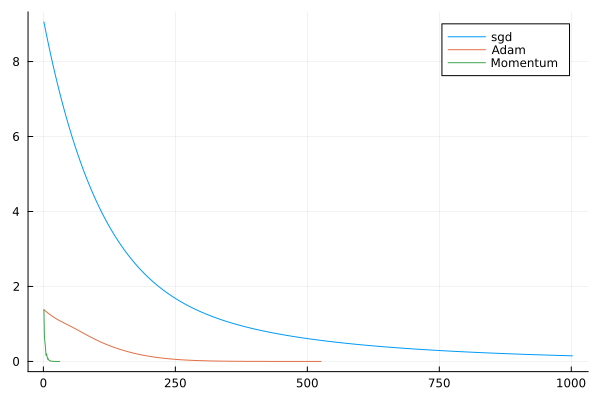

In [14]:
momentum = Charlotte.MomentumConstStep(0.5, 0.1)

accs = [Charlotte.Value(), Charlotte.NGrad(), Charlotte.ParamAccumulator(), Charlotte.DistTo(xstar)]
acc = Charlotte.Accumulator(accs)

state, accumulator = momentum(model; verbose = false, accumulator = acc);

all_acc_mom  = Charlotte.getData(accumulator);

plot!(p, all_acc_mom[:DistTo], label="Momentum")

Algorithm of type : Charlotte.NesterovConstStep{Float64}
 --- STOP after 20 iterations ---
 stop status: FixedGradientNorm
 fx = -2.716867467801732
 norm grad = 9.940210476559839e-5


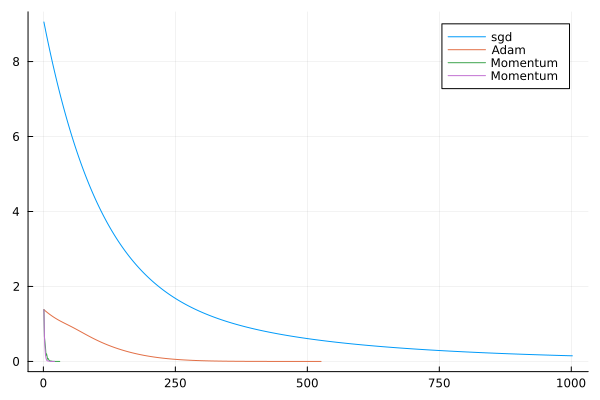

In [15]:
nesterov = Charlotte.NesterovConstStep(0.5, 0.1)

accs = [Charlotte.Value(), Charlotte.NGrad(), Charlotte.ParamAccumulator(), Charlotte.DistTo(xstar)]
acc = Charlotte.Accumulator(accs)

state, accumulator = nesterov(model; verbose = false, accumulator = acc);

all_acc_mom  = Charlotte.getData(accumulator);

plot!(p, all_acc_mom[:DistTo], label="Momentum")

# Amlet

In [16]:
using Amlet